In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier, Pool
import catboost
import numpy as np
from sklearn import model_selection, metrics
from pandas.api.types import is_numeric_dtype

In [4]:
#Загрузка датасета, замена значений, удаление колонок
hr_data = pd.read_csv('C:\Pytorch\HR-Employee-Attrition.csv')
hr_data.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis=1, inplace=True)
hr_data['Attrition'].replace({'Yes': 1, 'No': 0}, inplace=True)
X = hr_data.drop('Attrition', axis=1)
y = hr_data['Attrition']

In [5]:
def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if not(is_numeric_dtype(X[col])):
           cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies
def convert_cats(X):
    cats = []
    for col in X.columns:
        if not(is_numeric_dtype(X[col])):
            cats.append(col)
    cat_indicies = []
    for col in cats:
        X[col] = X[col].astype('category')
cat_features = get_categorical_indicies(X)
convert_cats(X)
print(cat_features)
X.info()

[1, 3, 6, 9, 13, 15, 19]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       1470 non-null   int64   
 1   BusinessTravel            1470 non-null   category
 2   DailyRate                 1470 non-null   int64   
 3   Department                1470 non-null   category
 4   DistanceFromHome          1470 non-null   int64   
 5   Education                 1470 non-null   int64   
 6   EducationField            1470 non-null   category
 7   EmployeeNumber            1470 non-null   int64   
 8   EnvironmentSatisfaction   1470 non-null   int64   
 9   Gender                    1470 non-null   category
 10  HourlyRate                1470 non-null   int64   
 11  JobInvolvement            1470 non-null   int64   
 12  JobLevel                  1470 non-null   int64   
 13  JobRole                

In [6]:
#Создание train и test набора данных
X = hr_data.drop('Attrition', axis=1)
y = hr_data['Attrition']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size=0.2, 
                                                                    random_state=0, stratify=y)
y_test.value_counts(normalize=True)

0    0.840136
1    0.159864
Name: Attrition, dtype: float64

In [7]:
#Пишем функции для построения ROC кривой, Feature_importances, confusion_matrix
#А также для отображения точности на кросс-валидации
def ROC_plot(clf, x):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(x)[:,1])
    roc_auc= metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='royalblue', lw=4, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
def FI_plot(clf):
    feats = {}
    for feature, importance in zip(X.columns, clf.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances[:10].reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale = 5)
    sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(30,15)
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='mediumpurple')
    plt.xlabel('Importance', fontsize=25, weight = 'bold')
    plt.ylabel('Features', fontsize=25, weight = 'bold')
    plt.title('Feature Importance (RandomForest)', fontsize=25, weight = 'bold')
    plt.show()
def CM_plot(clf):
    confusion_matrix = metrics.confusion_matrix(y_test, clf.predict(X_test))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
def catboost_cv(param_сb):
    catboost_cv = catboost.cv(params=param_сb,
                             pool=Pool(X_train, label=y_train, cat_features=cat_features),
                             fold_count=4,
                             partition_random_seed=0,
                             verbose=False,
                             stratified=True)
    best_value = np.max(catboost_cv['test-Accuracy-mean'])
    best_iter = np.argmax(catboost_cv['test-Accuracy-mean'])
    print(f'Лучшее значение кросс-валидации: {round(best_value, 3)} достигнуто на {best_iter} итерации')

In [26]:
cb_clf = CatBoostClassifier(cat_features=cat_features, random_seed=0, iterations=4000)
cb_clf.fit(X_train, y_train,verbose=False, cat_features=cat_features)
print(f"Model is fitted: {str(cb_clf.is_fitted())}")

Model is fitted: True


In [27]:
print(f'Сross_val_score:{round(model_selection.cross_val_score(cb_clf, X_train, y_train, cv=4).mean(), 3)}')

Learning rate set to 0.002739
0:	learn: 0.6910350	total: 24ms	remaining: 1m 35s
1:	learn: 0.6889753	total: 54.8ms	remaining: 1m 49s
2:	learn: 0.6872037	total: 85.2ms	remaining: 1m 53s
3:	learn: 0.6849397	total: 115ms	remaining: 1m 54s
4:	learn: 0.6829544	total: 146ms	remaining: 1m 56s
5:	learn: 0.6810046	total: 177ms	remaining: 1m 57s
6:	learn: 0.6792476	total: 209ms	remaining: 1m 59s
7:	learn: 0.6774344	total: 242ms	remaining: 2m
8:	learn: 0.6751974	total: 274ms	remaining: 2m 1s
9:	learn: 0.6734003	total: 305ms	remaining: 2m 1s
10:	learn: 0.6713137	total: 335ms	remaining: 2m 1s
11:	learn: 0.6696887	total: 365ms	remaining: 2m 1s
12:	learn: 0.6682915	total: 372ms	remaining: 1m 54s
13:	learn: 0.6660256	total: 401ms	remaining: 1m 54s
14:	learn: 0.6644213	total: 426ms	remaining: 1m 53s
15:	learn: 0.6626424	total: 457ms	remaining: 1m 53s
16:	learn: 0.6610116	total: 471ms	remaining: 1m 50s
17:	learn: 0.6594485	total: 491ms	remaining: 1m 48s
18:	learn: 0.6578832	total: 501ms	remaining: 1m 44s

KeyboardInterrupt: 

In [14]:
#Лучшее значение кросс-валидации: 0.875 достигнуто на 2623 итерации
paramiters = {}
paramiters['iterations'] = 3000
paramiters['learning_rate'] = 0.003096
paramiters['max_depth'] = 5
paramiters['l2_leaf_reg'] = 4
paramiters['random_seed'] = 0
paramiters['custom_loss'] = 'Accuracy'
paramiters['loss_function'] = 'Logloss'
catboost_cv(paramiters)

Training on fold [0/4]

bestTest = 0.3352425076
bestIteration = 2958

Training on fold [1/4]


KeyboardInterrupt: 

In [21]:
cb_clf_best = CatBoostClassifier(cat_features=cat_features, random_seed=0, learning_rate=0.003096,
                                iterations=2623, max_depth=5, l2_leaf_reg=4, custom_loss='Accuracy')
cb_clf_best.fit(X_train, y_train,verbose=False, cat_features=cat_features, plot=True)
print(f"Model is fitted: {str(cb_clf_best.is_fitted())}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted: True


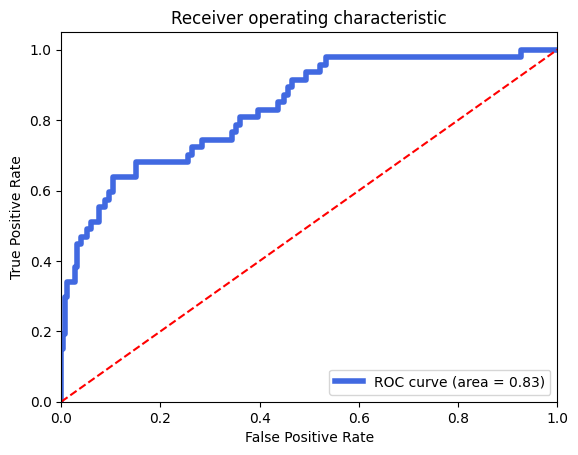

In [23]:
ROC_plot(cb_clf_best, X_test)

In [10]:
data_grid = {'set_iterations': [750, 1000, 1500, 2000, 2500, 3000, 3500],
             'auto_set_learning_rate': [0.012712, 0.009764,
                                        0.006732, 0.005171, 0.004214, 0.0035666, 0.003096],
             'best_cross_val_score': [0.87, 0.871, 0.87, 0.87, 0.869, 0.872, 0.872],
             'best_iteration': [568, 1105, 1187, 1941, 2013, 2837, 3359]}
data_grid = pd.DataFrame(data_grid)
data_grid.head()

,set_iterations,auto_set_learning_rate,best_cross_val_score,best_iteration
0,750,0.012712,0.870,568
1,1000,0.009764,0.871,1105
2,1500,0.006732,0.870,1187
3,2000,0.005171,0.870,1941
4,2500,0.004214,0.869,2013


In [15]:
data_grid[1:].head(6)

,set_iterations,auto_set_learning_rate,best_cross_val_score,best_iteration
1,1000,0.009764,0.871,1105
2,1500,0.006732,0.870,1187
3,2000,0.005171,0.870,1941
4,2500,0.004214,0.869,2013
5,3000,0.003567,0.872,2837
6,3500,0.003096,0.872,3359


In [ ]:
#Базовые значения iterations=1000, max_depth=6, l2_leaf_reg=3
paramiters = {}
paramiters['learning_rate'] = list(data_grid['auto_set_learning_rate'])
paramiters['max_depth'] = range(5,9)
paramiters['l2_leaf_reg'] = range(1,6)
cb_grid = CatBoostClassifier(random_seed=0, cat_features=cat_features,
                             iterations=4000, early_stopping_rounds=1500, custom_metric='Accuracy')
grid_search_result = cb_grid.grid_search(paramiters, X=X_train, y=y_train, cv=4,
                                         partition_random_seed=0, search_by_train_test_split=False,
                                         stratified=True, verbose=False, plot=True)
dd = pd.DataFrame(grid_search_result)
dd.to_pickle("grid_catboost.pkl")

In [ ]:
best_cb_clf = 